<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/main/A2_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [1]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import re
import math
import bisect
from scipy.stats import zscore
from scipy.io import arff
from importlib import reload

from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import load_svmlight_file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as skl_train_test_split

#import warnings
#warnings.filterwarnings('ignore')

np.random.seed(1234)

# a folder to store the saved graphs
#!mkdir images

# Data Handling

## Importing

In [2]:
### importing the files from the web to google colab

# retrieving the IMDB data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

# unzipping the tar.gz file into google colab for easy access
!tar -xf  'aclImdb_v1.tar.gz'

--2022-10-30 14:30:27--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  49.5MB/s    in 1.6s    

2022-10-30 14:30:29 (49.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Preprocessing

### Helper functions

In [3]:
def filter_svmlight(matrix, vocab):
  # boolean matrix for all values not equal to 0
  X_boolean = matrix != 0  

  # 1 X 1 matrix with the percentage of documents that includes each word (per column)
  X_doc_percentage = X_boolean.astype(int).sum(axis = 0) / matrix.shape[0]

  ''' finding the stopwords and rarewords '''

  # 1 X 1 boolean matrix indicates whether each column (word) is a stopword
  X_bool_stopwords = X_doc_percentage > 0.5

  # 1 X 1 boolean matrix indicates whether each column (word) is a rareword
  X_bool_rarewords = X_doc_percentage < 0.01

  # boolean list for whether each index (word) is not a stopword
  not_stopwords = [not word for word in X_bool_stopwords.tolist()[0]]

  # boolean list for whether each index (word) is not a rare word
  not_rarewords = [not word for word in X_bool_rarewords.tolist()[0]]

  ''' finding the column indices of words that are not stopwords or rare words '''

  not_stopword_indices = [index for index, x in enumerate(np.transpose(not_stopwords)) if x]
  not_rareword_indices = [index for index, x in enumerate(np.transpose(not_rarewords)) if x]

  # the intsersection of the two lists above are the indices of words that are neither
  # stopwords nor rare words
  not_stop_or_rare_indices = [index for index in not_stopword_indices if index in not_rareword_indices]

  ''' filtering for the words that are neither stopwords nor rare words '''

  # filters the original matrix
  X_filtered = matrix[:, not_stop_or_rare_indices]

  # filters the list of terms
  vocab_filtered = [vocab[index] for index in not_stop_or_rare_indices]

  return X_filtered, vocab_filtered

In [11]:
class linear_regression:
  def __init__(self, add_bias = True):
    self.add_bias = add_bias

  def fit(self, x, y):
    # if the dimension of x is 1
    if x.ndim == 1:
      # adds an extra dimension 
      # e.g., [1, 2, 3] -> [[1], [2], [3]]
      x = x[:, None]

    # the number of features
    N = x.shape[0]

    if self.add_bias:
      # adds bias by adding a constant feature of value 1
      # e.g., [[1], [2], [3]] -> [[1, 1], [2, 1], [3, 1]]
      x = np.column_stack([x, np.ones(N)])

    # w is the least square difference (w0 and w1)
    self.w = np.linalg.lstsq(x, y)[0]

    return self

  def predict(self, x):
    # the number of features
    N = x.shape[0]

    if self.add_bias:
      # adds bias by adding a constant feature of value 1
      # e.g., [[1], [2], [3]] -> [[1, 1], [2, 1], [3, 1]]
      x = np.column_stack([x, np.ones(N)])

    # predict the y values where @ denotes matrix multiplication
    # y = Xw
    yh = x @ self.w

    return yh


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


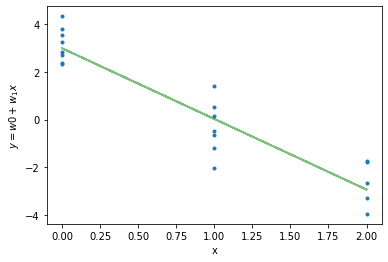

[-2.95597919  2.98225284]


In [13]:
N = 20
x = np.random.randint(0, 3, N)

y = 3 + -3*x + 1*np.random.randn(N)

model = linear_regression()

yh = model.fit(x, y).predict(x)

# plotting
plt.plot(x, y, '.')
plt.plot(x, yh, 'g-', alpha=.5)
plt.xlabel('x')
plt.ylabel(r'$y=w0 + w_1x$')
plt.show()

print(model.w)

In [26]:
def standardize_array(arr):
  standardized_array = []

  mean_val = arr.mean()
  standard_dev = arr.std()

  for i in arr:
    new_val = (i - mean_val) / standard_dev
    standardized_array.append(new_val)

  return standardized_array

In [57]:
def standardize_list(list):
  standardized_list = []

  mean_val = sum(list) / len(list)
  standard_dev = np.std(list)

  for i in list:
    new_val = (i - mean_val) / standard_dev
    standardized_list.append(new_val)

  return standardized_list

In [88]:
def compute_zscores(df):
  y = df.iloc[:, -1]
  y_stan = standardize_list(y.tolist())

  N = df.shape[0]

  z_scores = []

  for col in df:
    x_stan = standardize_list(df[col].tolist())
    col_z_score = (np.transpose(x_stan) @ y_stan) / math.sqrt(N)

    z_scores.append(col_z_score)

  return z_scores

### Loading and cleaning IMDB data

In [4]:
### loading the svm files into sparse matrices

# X is the sparse matrix, y are the labels
X_IMDB_train, y_IMDB_train = load_svmlight_file('aclImdb/train/labeledBow.feat', dtype=int)

# X is the sparse matrix, y are the labels
#X_IMDB_test, y_IMDB_test = load_svmlight_file('aclImdb/test/labeledBow.feat', dtype=int)

# saving a list of the terms/vocab
IMDB_vocab = [line.rstrip() for line in open('aclImdb/imdb.vocab')]

In [5]:
### filtering the IMDB matrices to remove stop words and rare words

X_IMDB_train_filtered, IMDB_train_vocab_filtered = filter_svmlight(X_IMDB_train, IMDB_vocab)
#X_IMDB_test_filtered, IMDB_test_vocab_filtered = filter_svmlight(X_IMDB_test, IMDB_vocab)

In [6]:
### creates dataframes out of the words that are neither stopwords nor rare words

IMDB_train_df = pd.DataFrame(X_IMDB_train_filtered.toarray(), columns = IMDB_train_vocab_filtered)
#IMDB_test_df = pd.DataFrame(X_IMDB_test_filtered.toarray(), columns = IMDB_test_vocab_filtered)

# adds the target labels as a column
IMDB_train_df['LABEL'] = y_IMDB_train.astype(int)
#IMDB_test_df['LABEL'] = y_IMDB_test.astype(int)

In [7]:
IMDB_train_df

,he,his,!,by,an,who,they,from,so,like,...,portray,length,discovered,aware,continues,below,opens,essentially,received,LABEL
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,1,0,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,7
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,1,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,5,0,9,3,1,7,3,2,1,0,...,0,0,0,0,0,1,0,0,0,1
24996,2,2,1,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1
24997,0,2,0,2,1,2,3,1,0,3,...,0,0,0,0,0,0,1,0,0,4
24998,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


### Loading and cleaning 20 News Groups

In [8]:
### selecting 4 categories and extracting the data from sklearn

fav_four = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.politics.guns']

# 20 news groups training
twenty_train = fetch_20newsgroups(subset='train', categories=fav_four, remove=(['headers', 'footers', 'quotes']))
# 20 news groups testing
twenty_test = fetch_20newsgroups(subset='test', categories=fav_four, remove=(['headers', 'footers', 'quotes']))

In [100]:
### transforming the data into vectors

# creating a new CountVectorizer object
count_vect = CountVectorizer(max_df=0.5, min_df=0.01)

# builds a dictionary of features and transforms documents to feature
# vectors where each index represents the occurrence of a specific word
X_train_counts = count_vect.fit_transform(twenty_train.data)

# retrieving the names of the features
feature_names = count_vect.get_feature_names()

# creating a dataframe in which row represents a document and each column
# a word
X_twenty_train_df = pd.DataFrame(X_train_counts.toarray(), columns = feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [101]:
X_twenty_train_df

,00,000,01,04,10,100,1000,11,12,13,...,yeah,year,years,yes,yesterday,yet,york,you,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,8,3,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0


### Determining important features for IMDB data

In [91]:
### computing z-score of each feature

z_scores = compute_zscores(IMDB_train_df)

# Implementing models

## Helper functions

## Logistic regression

## Multi-class regression

# Running experiments

### Helper functions

## Logistic regression experiments

### Baseline accuracy tests

## Multi-class regression experiments

### Baseline accuracy tests
